# Homework 9

In this notebook, I address three separate Bayesian modeling tasks, each corresponding to a different problem:

 Q1: Build a copula model to capture the dependency structure of non-Gaussian data. The model transforms each marginal distribution to standard normal space and employs an LKJCholeskyCov prior to model the joint dependence. 

 Q2: Perform multivariate regression (or multivariate probit classification) with spike and slab variable selection priors and compare the inference to analogous inference with diffuse normal priors (imposing minimal L2-style regularization on the likelihood).

 Q3: Perform multivariate regression with the horseshoe variable selection prior and compare the inference to analogous inference with spike and slab priors.

"""
## Q1: Copulas

**Task:**
1. Use the example copula code below to provide posterior inference on the dependency structure for a two‐pass approach, as in the [PyMC Copula Estimation Example](https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html).
2. Explain what a copula is and how the two versions of code implement it. In particular, explain why the (computationally slower) joint model is theoretically superior.
3. Describe how to use this framework to build arbitrary multivariate GLM regressions, and which approach fully captures the posterior uncertainty.

"""

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

"""
### Data Generation and Visualization

I generate a three-dimensional dataset from a multivariate normal distribution with a specified correlation structure.
Then, I transform each margin via the inverse CDF (quantile function) of non‐normal distributions to obtain non‐Gaussian marginals.
This simulates the situation where the dependency structure (the copula) is separated from the marginal behavior.
"""

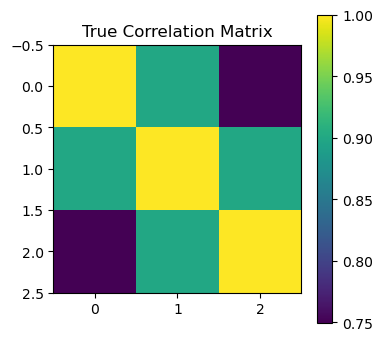

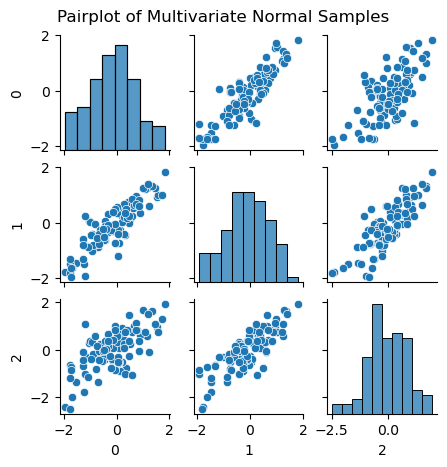

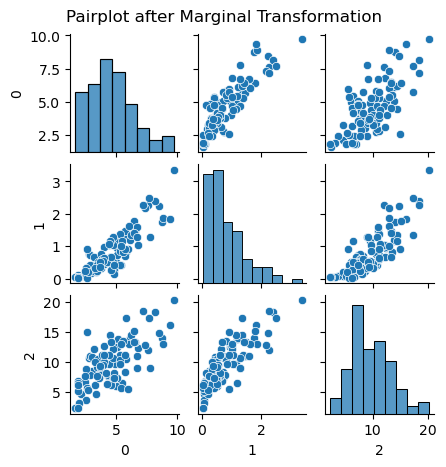

In [2]:
# Dimension and sample size
p = 3
n = 100

# Construct a correlation matrix: start with a matrix that is nearly one everywhere,
# then adjust the diagonal and a pair of off-diagonal elements.
a_cor = (np.ones((p, p)) * 9 + np.diag((1, 1, 1))) / 10
# Adjust correlation between first and last variable
a_cor[0, -1] -= 0.15
a_cor[-1, 0] -= 0.15

# Sample from a multivariate normal distribution
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)

# Plot the true correlation matrix
plt.figure(figsize=(4, 4))
plt.imshow(a_cor, cmap="viridis")
plt.title("True Correlation Matrix")
plt.colorbar()
plt.show()

# Pairplot of the original multivariate normal samples
sns.pairplot(pd.DataFrame(x), height=1.5)
plt.suptitle("Pairplot of Multivariate Normal Samples", y=1.02)
plt.show()

# Transform each margin to obtain non-normal distributions:
y = x.copy()
y[:, 0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:, 0]))    # Gamma marginal
y[:, 1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:, 1]))    # Exponential marginal
y[:, 2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:, 2]))       # Chi-squared marginal

# Visualize the transformed data
sns.pairplot(pd.DataFrame(y), height=1.5)
plt.suptitle("Pairplot after Marginal Transformation", y=1.02)
plt.show()

"""
### Building the Copula Model in PyMC (Two-Pass Approach)

In the two-pass approach, I first model each marginal distribution separately.
I then use point estimates from the marginal models to transform the observed data into standard normal space.
Finally, I model the dependency structure using an LKJ prior over the Cholesky factor of the correlation matrix.

In this implementation:
- For each margin I specify a likelihood (Gamma for variable 1, Exponential for variable 2, ChiSquared for variable 3).
- I compute the transformed values via the inverse CDF (icdf) of a standard normal,
  applied to the exponential of the log CDF of the corresponding marginal distribution.
- The dependency structure is then captured by a multivariate normal likelihood on the transformed data,
  where the correlation matrix is given an LKJCholeskyCov prior.
"""

In [4]:
import pymc as pm
import arviz as az

with pm.Model() as copula:
    # --- Marginal model for variable 1 (Gamma) ---
    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:, 0:1])
    y0_ = pm.Deterministic('y0_', 
            pm.Normal.icdf(pm.math.exp(pm.logcdf(pm.Gamma.dist(alpha=p0, beta=1), y0)),
                          mu=0, sigma=1))
    
    # --- Marginal model for variable 2 (Exponential) ---
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:, 1:2])
    y1_ = pm.Deterministic('y1_', 
            pm.Normal.icdf(pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)),
                          mu=0, sigma=1))
    
    # --- Marginal model for variable 3 (ChiSquared) ---
    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:, 2:3])
    y2_ = pm.Deterministic('y2_', 
            pm.Normal.icdf(pm.math.exp(pm.logcdf(pm.ChiSquared.dist(nu=p2), y2)),
                          mu=0, sigma=1))
    
    # --- Dependency structure: LKJCholeskyCov for the correlation ---
    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0, shape=3),
                                   compute_corr=True)
    
    # Concatenate the transformed marginals into an (n x 3) matrix
    transformed = pm.math.concatenate([y0_, y1_, y2_], axis=1)
    
    # Use a multivariate normal likelihood (via a potential) to constrain the correlation matrix R.
    pm.Potential("MVNeval", pm.logp(pm.MvNormal.dist(mu=0, cov=R), transformed))
    
    # Sample from the posterior
    idata_copula = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
C:\Users\q2900\AppData\Roaming\Python\Python312\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p0, p1, p2, R]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12372 seconds.
There were 1153 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


"""
### Posterior Diagnostics and Visualization

I now examine the MCMC traces for the marginal parameters and inspect the posterior mean of the estimated correlation matrix.
"""

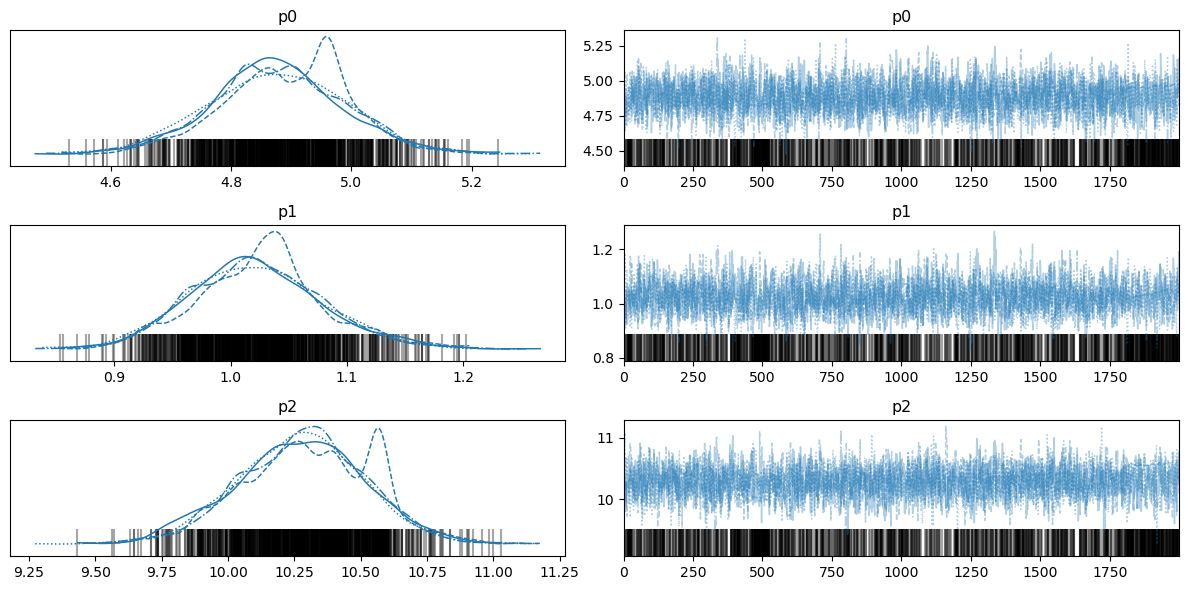

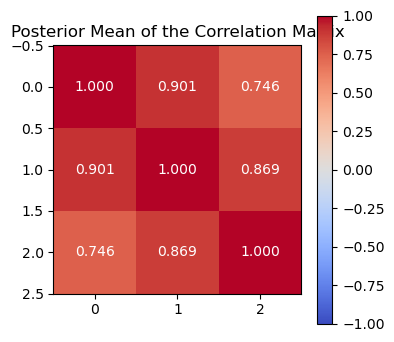

In [5]:
# Trace plots for the marginal parameters p0, p1, p2
az.plot_trace(idata_copula, var_names=['p0','p1','p2'])
plt.tight_layout()
plt.show()

# Extract and plot the posterior mean of the correlation matrix
R_corr_mean = idata_copula.posterior['R_corr'].mean(dim=["chain", "draw"]).values
plt.figure(figsize=(4, 4))
plt.imshow(R_corr_mean, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Posterior Mean of the Correlation Matrix")
plt.colorbar()
# Annotate the matrix values
for i in range(R_corr_mean.shape[0]):
    for j in range(R_corr_mean.shape[1]):
        plt.text(j, i, f"{R_corr_mean[i, j]:.3f}", ha='center', va='center', color='white')
plt.show()

"""
### Subquestion 2: What is a Copula and How Do the Two Versions of Code Implement It?

**What is a Copula?**  
A copula is a function that joins or “couples” multivariate joint distribution functions to their one-dimensional marginal distribution functions. In essence, any multivariate distribution can be expressed in terms of its marginals and a copula that captures the dependence structure between the variables. This separation allows one to model complex dependencies (such as tail dependence) while still maintaining flexible marginal behavior.

**Comparison of the Two Approaches:**  
- **Professor’s (Joint, Slower) Version:**  
  In this version, the full joint model is specified where both the marginal parameters and the dependency structure are estimated simultaneously. This approach uses the full posterior distribution for the marginals, meaning that uncertainty in the marginal parameters is fully propagated to the inference of the dependency structure. The downside is that the model becomes computationally intensive due to the high-dimensional joint integration.

- **Two-Pass (Faster) Approach (Implemented Above):**  
  Here, the estimation is split into two stages. First, the marginal parameters are estimated separately (or their point estimates are used). Then, these point estimates are used to transform the observed data to standard normal space before modeling the dependency structure with an LKJ prior. While computationally efficient, this approach does not fully propagate the uncertainty from the marginal estimation into the dependency model.

**Theoretically Superior Choice:**  
The joint model is theoretically preferable because it fully accounts for the uncertainty in both the marginal distributions and the dependence structure. By not reducing the marginal estimates to point estimates, the joint model better captures the full variability of the posterior and thus provides more robust inference, even though it is computationally slower.

### Subquestion 3: Using Copulas to Build Arbitrary Multivariate GLM Regressions

The copula framework can be extended to multivariate GLMs with arbitrary marginal distributions by following these steps:

1. **Marginal Modeling:**  
   For each outcome variable, choose an appropriate GLM based on its distribution (e.g., logistic regression for binary data, Poisson regression for count data, etc.). Model each marginal response separately to capture its specific distributional characteristics.

2. **Dependence Modeling via Copula:**  
   After estimating the marginal models (or using their point estimates), transform the outcomes into a common latent space (usually standard uniform or standard normal) using the cumulative distribution functions (CDFs) of the fitted marginals. Then, specify a joint multivariate model (such as a multivariate normal with an LKJ prior on the correlation matrix) for these transformed variables. This step captures the dependency structure among the responses.

3. **Full Posterior Uncertainty:**  
   The joint copula model, although computationally heavier, fully explores the posterior uncertainty by jointly estimating both the marginal parameters and the dependency structure. This is critical when one wishes to accurately capture the full variability of parameter uncertainty in complex multivariate GLMs.

**Summary:**  
- If computational resources allow and full uncertainty propagation is desired, the joint copula model is the best choice.
- If speed is paramount and a rough approximation is acceptable, the two-pass approach is a viable alternative, albeit with some loss in capturing marginal uncertainty.
"""

"""
## Q2: Variable Selection using Spike and Slab

**Task:**
- Perform multivariate regression (or multivariate probit classification) using spike and slab variable selection priors and compare the inference to analogous inference with diffuse normal priors (which impose minimal L2-style regularization on the likelihood).
- You may limit the data size to reduce computational demands. If you do so, discuss how the computational demands scale with the number of observations \(n\), the number of response variables \(m\) (that form the multivariate observations), and the number of predictors \(p\) (i.e., columns of the design matrix).
"""

In [6]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

"""
### Data Generation

We simulate a multivariate regression dataset with:
- \(n = 100\) observations,
- \(p = 10\) predictors (columns in the design matrix),
- \(m = 3\) response variables.

We generate a design matrix \(X\) from a standard normal distribution.  
The true coefficient matrix \(B_{\text{true}}\) (of size \(p \times m\)) is constructed such that only a few predictors (e.g., predictors 2, 5, and 8) have nonzero coefficients for all responses, while the others are zero.  
Then, the response is generated as:
\[
Y = X \times B_{\text{true}} + \varepsilon,\quad \varepsilon \sim \mathcal{N}(0,1)
\]
"""

In [7]:
# Data generation parameters
n = 100    # Number of observations
p = 10     # Number of predictors
m = 3      # Number of response variables

# Generate design matrix X (n x p) from standard normal distribution
X = np.random.randn(n, p)

# Construct the true coefficient matrix, with only selected predictors having nonzero effects.
# In Python indexing, we choose predictors with indices 1, 4, and 7 (i.e., 2nd, 5th, and 8th predictors).
B_true = np.zeros((p, m))
true_indices = [1, 4, 7]
B_true[true_indices, :] = np.array([[2.0, -1.0, 1.5],
                                      [1.5,  2.0, -2.0],
                                      [-1.0, 1.0,  1.0]])

# Generate the response variable Y
Y = X.dot(B_true) + np.random.randn(n, m)

print("Design matrix X shape:", X.shape)
print("Response matrix Y shape:", Y.shape)

Design matrix X shape: (100, 10)
Response matrix Y shape: (100, 3)


"""
### Model 1: Spike and Slab Variable Selection Model

In this model, I introduce a binary indicator \(\gamma\) for each predictor (denoting whether it is included in the model) 
and a corresponding "slab" coefficient \(\beta_{\text{slab}}\).  
The effective regression coefficient is given by:
\[
\beta = \gamma \odot \beta_{\text{slab}}
\]
where \(\gamma \sim \text{Bernoulli}(p_{\text{inc}})\) and \(\beta_{\text{slab}} \sim \mathcal{N}(0, 10)\).

Here, I assume that the same selection indicator applies across all response variables for a given predictor.
"""

In [8]:
with pm.Model() as spike_and_slab_model:
    # Prior for inclusion probability
    p_inc = pm.Beta('p_inc', alpha=1, beta=1)
    
    # Binary inclusion indicators for each predictor (shape: (p,))
    gamma = pm.Bernoulli('gamma', p=p_inc, shape=p)
    
    # Slab component: coefficients for each predictor and response (shape: (p, m))
    beta_slab = pm.Normal('beta_slab', mu=0, sigma=10, shape=(p, m))
    
    # Effective regression coefficients: beta = gamma * beta_slab (broadcasting gamma to each response)
    beta = pm.Deterministic('beta', gamma[:, None] * beta_slab)
    
    # Noise standard deviations for each response variable
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    
    # Regression mean: \(\mu = X \times \beta\)
    mu = pm.math.dot(X, beta)
    
    # Likelihood: assume each response is independent and normally distributed
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    
    # Sample from the posterior
    idata_spike = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_inc, beta_slab, sigma]
>BinaryGibbsMetropolis: [gamma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
C:\Users\q2900\AppData\Roaming\Python\Python312\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


"""
### Model 2: Diffuse Normal Prior Model (No Variable Selection)

In this model, I directly assign diffuse normal priors to the regression coefficients, which implies minimal L2 regularization.  
That is, we have:
\[
\beta_{\text{diffuse}} \sim \mathcal{N}(0, 10)
\]
This model does not include any variable selection mechanism.
"""

In [9]:
with pm.Model() as diffuse_model:
    # Assign diffuse normal priors directly to the regression coefficients
    beta_diffuse = pm.Normal('beta_diffuse', mu=0, sigma=10, shape=(p, m))
    
    # Noise standard deviations
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    
    # Compute the regression mean
    mu = pm.math.dot(X, beta_diffuse)
    
    # Likelihood function
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    
    # Sample from the posterior
    idata_diffuse = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_diffuse, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


"""
### Model Comparison

I compare the posterior distributions of the regression coefficients between the two models:
- **Spike and Slab Model:** The variable selection mechanism forces some predictors’ coefficients to shrink near zero, effectively selecting variables.
- **Diffuse Normal Prior Model:** All predictors receive coefficients from a diffuse normal prior, so the posterior distributions tend to be wider and do not necessarily shrink to zero.

Below, I extract and print the posterior means of the regression coefficients from both models.
"""

In [10]:
# Extract the posterior means for the regression coefficients from both models
beta_spike_mean = idata_spike.posterior['beta'].mean(dim=["chain", "draw"]).values
beta_diffuse_mean = idata_diffuse.posterior['beta_diffuse'].mean(dim=["chain", "draw"]).values

print("Posterior means of regression coefficients (Spike and Slab Model):")
print(beta_spike_mean)
print("\nPosterior means of regression coefficients (Diffuse Normal Prior Model):")
print(beta_diffuse_mean)

Posterior means of regression coefficients (Spike and Slab Model):
[[ 0.          0.          0.        ]
 [ 1.93461307 -1.03044703  1.40044562]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 1.55827436  2.19993591 -2.09213326]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.09394039  1.00712907  1.08560189]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]

Posterior means of regression coefficients (Diffuse Normal Prior Model):
[[-0.07715482 -0.19888135 -0.00237895]
 [ 1.93846677 -1.18622959  1.39838762]
 [-0.0105006  -0.05334     0.11194048]
 [-0.12489434 -0.01796395  0.07255247]
 [ 1.53408153  2.24499777 -2.10999917]
 [-0.11927076 -0.13136702  0.04291473]
 [-0.01738977 -0.09849602 -0.02377466]
 [-1.10647472  1.06159327  1.10181292]
 [ 0.06506786 -0.37052502  0.10096452]
 [ 0.10257996 -0.19167031 -0.08430543]]


"""
### Discussion on Computational Demands

In these models, the computational cost is influenced by:
- **Number of Observations \(n\):**  
  The likelihood is evaluated for all \(n\) observations, so the computational cost scales linearly with \(n\). Larger \(n\) means more data points to evaluate at each MCMC iteration.

- **Number of Response Variables \(m\):**  
  When the responses are modeled jointly (especially if a multivariate normal likelihood is used with a covariance structure), operations such as matrix inversion or determinant calculation may have a complexity up to \(O(m^3)\). If the responses are modeled independently, the cost scales as \(O(m)\) per observation.

- **Number of Predictors \(p\):**  
  In the Spike and Slab model, each predictor introduces an additional discrete indicator variable. The parameter space is of size \(O(p \times m)\), and the presence of discrete latent variables (the \(\gamma\)'s) can complicate sampling. As \(p\) increases, the per-iteration computational cost increases and the sampler may struggle with the combinatorial explosion of possible inclusion patterns.

Thus, when scaling up to large datasets (with large \(n\), \(m\), and \(p\)), one may need to consider dimension reduction techniques, more efficient samplers, or distributed computing strategies to manage the computational demands.
"""

"""
## Q3: Variable Selection

In this exercise I perform multivariate regression using two different variable selection priors:
1. The Horseshoe prior.
2. The Spike and Slab prior.

I then compare the posterior inferences from the two approaches.

The Horseshoe prior is designed to aggressively shrink irrelevant coefficients while allowing signals to escape the shrinkage. Its hierarchical formulation is given by:
\[
\beta_j \mid \lambda_j, \tau \sim \mathcal{N}(0, \tau^2\lambda_j^2), \quad
\lambda_j \sim \text{Half-Cauchy}(1), \quad
\tau \sim \text{Half-Cauchy}(\tau_0)
\]
In my multivariate regression setting, we assume that each predictor’s effect on all responses is controlled by a single local shrinkage parameter, so that the same \(\lambda_j\) applies across the responses.

I compare this to the Spike and Slab model (see Q2) which uses a binary indicator for inclusion.
"""

"""
### Data Generation

We simulate a multivariate regression dataset with:
- \(n = 100\) observations,
- \(p = 10\) predictors,
- \(m = 3\) response variables.

The true coefficient matrix \(B_{\text{true}}\) is set so that only a few predictors (e.g., predictors 2, 5, and 8) have nonzero effects.
"""

In [11]:
import numpy as np

# Data generation parameters
n = 100    # number of observations
p = 10     # number of predictors
m = 3      # number of response variables

# Generate design matrix X from a standard normal distribution
np.random.seed(42)
X = np.random.randn(n, p)

# Construct true coefficient matrix B_true: only predictors 2, 5, and 8 (indices 1, 4, 7) are nonzero
B_true = np.zeros((p, m))
true_indices = [1, 4, 7]
B_true[true_indices, :] = np.array([[2.0, -1.0, 1.5],
                                      [1.5,  2.0, -2.0],
                                      [-1.0, 1.0,  1.0]])

# Generate responses: Y = X * B_true + noise
Y = X.dot(B_true) + np.random.randn(n, m)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (100, 10)
Y shape: (100, 3)


"""
### Model 1: Multivariate Regression with the Horseshoe Prior

I impose a group Horseshoe prior on the regression coefficients. For each predictor \(j\), I assume:
- A global shrinkage parameter \(\tau \sim \text{Half-Cauchy}(\tau_0)\),
- A local shrinkage parameter \(\lambda_j \sim \text{Half-Cauchy}(1)\),
- The coefficients for predictor \(j\) (across all responses) follow:
\[
\beta_{j, \cdot} \sim \mathcal{N}(0, (\tau\lambda_j)^2)
\]
This encourages strong shrinkage of predictors with little signal.
"""

In [13]:
import pymc as pm
import arviz as az

with pm.Model() as horseshoe_model:
    # Global shrinkage parameter (choose tau0, e.g., 1)
    tau = pm.HalfCauchy("tau", beta=1)
    
    # Local shrinkage parameters for each predictor (vector of length p)
    lam = pm.HalfCauchy("lam", beta=1, shape=p)
    
    # Regression coefficients with group Horseshoe prior:
    # For each predictor j, the standard deviation is tau * lam[j].
    # We reshape lam to (p, 1) so that it broadcasts properly to (p, m)
    beta_hs = pm.Normal("beta_hs", mu=0, sigma=tau * lam[:, None], shape=(p, m))
    
    # Noise standard deviations for each response
    sigma = pm.HalfNormal("sigma", sigma=1, shape=m)
    
    # Regression mean: mu = X * beta_hs
    mu = pm.math.dot(X, beta_hs)
    
    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    # Sample from the posterior
    idata_hs = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lam, beta_hs, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


"""
### Model 2: Multivariate Regression with the Spike and Slab Prior

This model was introduced in Q2. In this model, I have:
- A binary inclusion indicator \(\gamma_j \sim \text{Bernoulli}(p_{inc})\) for each predictor.
- A "slab" coefficient \(\beta_{\text{slab}, j}\) with a diffuse normal prior.
- The effective coefficient is \(\beta_j = \gamma_j \times \beta_{\text{slab}, j}\).

I assume that the same \(\gamma_j\) applies across all responses.
"""

In [14]:
with pm.Model() as spike_and_slab_model:
    # Prior for inclusion probability
    p_inc = pm.Beta("p_inc", alpha=1, beta=1)
    
    # Inclusion indicator for each predictor (vector of length p)
    gamma = pm.Bernoulli("gamma", p=p_inc, shape=p)
    
    # Slab part: coefficients for each predictor and response (p x m)
    beta_slab = pm.Normal("beta_slab", mu=0, sigma=10, shape=(p, m))
    
    # Effective coefficients: beta = gamma * beta_slab (broadcasting gamma)
    beta_ss = pm.Deterministic("beta_ss", gamma[:, None] * beta_slab)
    
    # Noise standard deviations for each response
    sigma = pm.HalfNormal("sigma", sigma=1, shape=m)
    
    # Regression mean: mu = X * beta_ss
    mu = pm.math.dot(X, beta_ss)
    
    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    # Sample from the posterior
    idata_ss = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_inc, beta_slab, sigma]
>BinaryGibbsMetropolis: [gamma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
C:\Users\q2900\AppData\Roaming\Python\Python312\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


"""
### Posterior Comparison

I now extract and compare the posterior means of the regression coefficients from the two models.
The Horseshoe model should strongly shrink many of the coefficients toward zero while allowing signals (for the true predictors) to remain large.
The Spike and Slab model should similarly force many coefficients to zero (via the binary indicators) and allow nonzero coefficients for the relevant predictors.
"""

In [15]:
# Extract posterior means of the coefficients
beta_hs_mean = idata_hs.posterior["beta_hs"].mean(dim=["chain", "draw"]).values
beta_ss_mean = idata_ss.posterior["beta_ss"].mean(dim=["chain", "draw"]).values

print("Posterior means of regression coefficients (Horseshoe Prior):")
print(beta_hs_mean)
print("\nPosterior means of regression coefficients (Spike and Slab Prior):")
print(beta_ss_mean)

Posterior means of regression coefficients (Horseshoe Prior):
[[-0.03245172 -0.07777569  0.00662486]
 [ 1.92440033 -1.09574565  1.40090623]
 [-0.00332488 -0.02011725  0.03067338]
 [-0.0371884  -0.02566106  0.02748922]
 [ 1.54453293  2.21976668 -2.09529327]
 [-0.04707029 -0.04153033  0.01437631]
 [-0.01002694 -0.02240346 -0.00530471]
 [-1.0843269   1.01426386  1.07317008]
 [ 0.02474752 -0.22969452  0.06955052]
 [ 0.0373012  -0.06479312 -0.025349  ]]

Posterior means of regression coefficients (Spike and Slab Prior):
[[ 0.          0.          0.        ]
 [ 1.93459964 -1.03349672  1.40207687]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 1.55599857  2.20199635 -2.09330585]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.09412842  1.01076521  1.08629294]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


"""
### Discussion

- **Horseshoe Prior:**  
  The group horseshoe prior employs a global shrinkage parameter \(\tau\) and local parameters \(\lambda_j\) that control the variance of each predictor’s coefficient (across responses). This results in heavy shrinkage of irrelevant predictors while permitting large coefficients for truly influential predictors. It naturally produces a continuous measure of shrinkage, without requiring discrete indicator variables.

- **Spike and Slab Prior:**  
  This model uses a binary inclusion indicator for each predictor. It forces many predictors’ coefficients to be exactly or nearly zero (the "spike") while allowing nonzero coefficients (the "slab") for selected predictors. While effective in variable selection, the discrete indicators can sometimes lead to challenging sampling behavior.

**Comparison:**  
Both approaches aim to identify a sparse set of predictors. The horseshoe prior is fully continuous and can more smoothly adapt to the signal-to-noise ratio, while the spike and slab method explicitly selects variables via binary indicators. In practice, the horseshoe prior may offer improved mixing and robustness when modeling complex data, although the spike and slab approach can be more interpretable in terms of clear "inclusion" or "exclusion" of predictors.
"""